## Classificação de Texto no Dataset ``Hate Speech and Offensive Language Dataset``

Este projeto tem como objetivo construir, analisar e melhorar uma pipeline de classificação de textos utilizando um dataset de classificação previamente rotulado. Através de métodos de processamento de linguagem natural (NLP), análises de erros e modelagem de tópicos, foi buscado entender o desempenho do modelo e identificar formas de aprimorá-lo.

## 1. Obter o Dataset

O dataset ``Hate Speech and Offensive Language Dataset`` utilizado para a classificação de texto pode ser baixado do **Kaggle**, o link você pode encontrar clicando [aqui](https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset?resource=download), assim como o paper original da aplicação você pode encontrar [aqui](https://arxiv.org/pdf/1703.04009).

### Aplicação

Um desafio inerente ao contexto de redes sociais é a classificação automática de instâncias de textos tóxicos, tais como o discurso de ódio e a linguagem ofensiva. Nesse sentido, a classificação automática se torna uma tarefa fundamental para a identificação de conteúdo nocivo e a proteção de usuários vulneráveis. Neste projeto, utilizamos um dataset de classificação de texto para treinar um modelo de classificação de texto capaz de identificar automaticamente conteúdo tóxico em redes sociais com base em tweets.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import string

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler


# Inicializa o lemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para outras línguas, se necessário
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the data
data = pd.read_csv('../data/labeled_data.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Pré-processamento

A pipeline completa foi dividida em duas etapas: ``prepro_features`` e  ``pipeline``. A primeira etapa é responsável por realizar o pré-processamento dos dados, enquanto a segunda etapa é responsável por treinar o modelo de classificação e avaliar seu desempenho. 

Para o pré-processamento dos textos, foram utilizadas as seguintes técnicas:

- Remoção de stopwords e pontuação
- Lematização
- Vetorização com TF-IDF

Dessa forma, a implementação você pode acompanhar abaixo:

In [2]:
class PreproTweets(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        # print(text)
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
        return text

# Exemplo de pipeline com pré-processamento e TF-IDF
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

X, y = texts, target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('log_reg', LogisticRegression())])

In [4]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

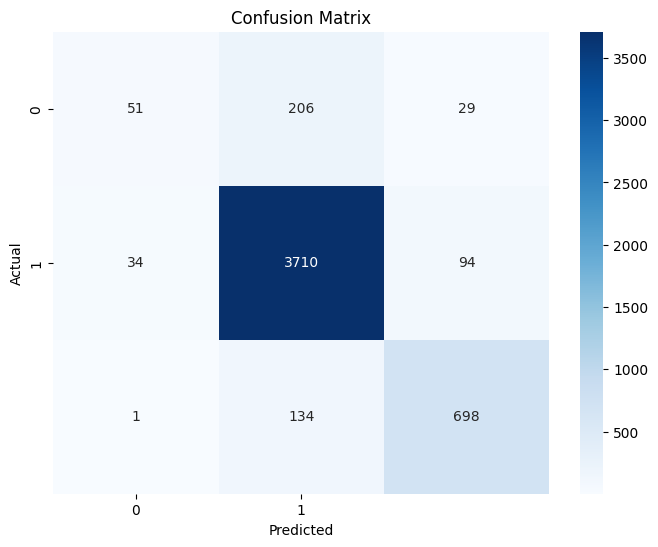

In [5]:
# confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# precision, recall e f1-score

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.18      0.27       286
           1       0.92      0.97      0.94      3838
           2       0.85      0.84      0.84       833

    accuracy                           0.90      4957
   macro avg       0.79      0.66      0.69      4957
weighted avg       0.89      0.90      0.89      4957



### Junção de classes

Devido a complexidade envolvida em classificar **hate speech e offensive language**, vamos considerar a classificação de **offensive language & hate speech** como sendo uma só (0), transformando o problema numa classificação binária. O intuito dessa abordagem é simplificar o problema e tornar o modelo mais eficiente.

#### Antes:

- 0 - ``Hate Speech``
- 1 - ``Offensive Language``
- 2 - ``Neither``

#### Depois:

- 0 - ``Hate Speech & Offensive Language``
- 1 - ``Neither``

### Equilibrando datasets

Além disso, vamos também equilibrar os datasets para que o modelo não seja enviesado para uma classe específica. Para isso, vamos utilizar a técnica de **undersampling**.

In [7]:
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

target = target.apply(lambda x: x//2)
texts_target = pd.concat([texts, target], axis=1)

down_sample = target.value_counts().min()
texts_target_undersampled = pd.concat([texts_target[texts_target['class'] == 0].sample(down_sample, random_state=42),
                                        texts_target[texts_target['class'] == 1]])

X, y = texts_target_undersampled['tweet'], texts_target_undersampled['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('log_reg', LogisticRegression())])

In [9]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

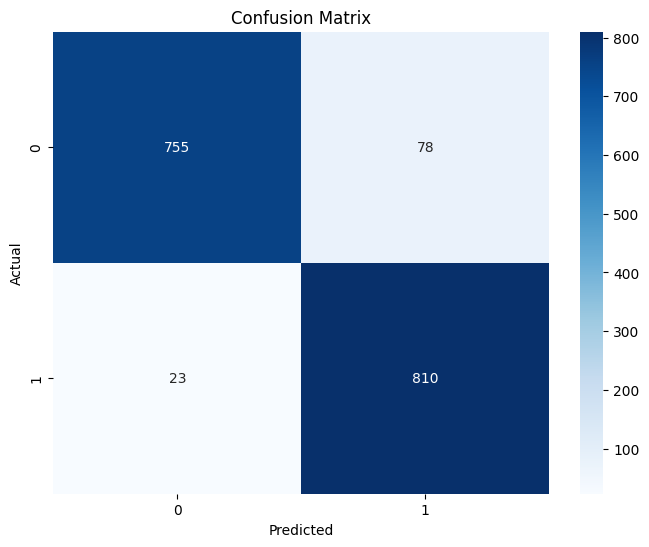

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       833
           1       0.91      0.97      0.94       833

    accuracy                           0.94      1666
   macro avg       0.94      0.94      0.94      1666
weighted avg       0.94      0.94      0.94      1666



In [12]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'Precision Score: {precision_score(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

F1 Score: 0.9413131900058106
Recall Score: 0.9723889555822329
Precision Score: 0.9121621621621622
Accuracy Score: 0.93937575030012


## Como identificar instâncias que confundem o classificador (dúvida)?

Vamos ordenar as instâncias de acordo com a entropia de suas probabilidades, dessa forma, as instâncias que o modelo tem mais dificuldade de classificar serão as primeiras a serem analisadas.

In [13]:
def func_entropy(p):
    return np.sum([-p_i * np.log2(p_i) for p_i in p], axis=1)

In [14]:
entropy = func_entropy(pipeline.predict_proba(X_test))
p = pipeline.predict_proba(X_test)[:, 0]

In [15]:
df = pd.DataFrame({'tweet': X_test, 'class': y_test, 'entropy': entropy, 'p_hate_offensive': p})

In [16]:
df.sort_values('entropy', ascending=False).head(10)

,tweet,class,entropy,p_hate_offensive
860,"#porn,#android,#iphone,#ipad,#sex,#xxx, | #Ana...",0,1.000000,0.499783
23237,You all are retarded if you really Kendrick wa...,1,0.999952,0.495906
1162,&#8220;@CRYaboutitNIGGA: I get paid too chill....,1,0.999892,0.493896
17664,RT @TheFakeESPN: Rutgers terminated Mike Rice'...,0,0.999877,0.493460
5684,@cambreezy_ @AndrewWayne2 @thereal_EMandM it a...,0,0.999767,0.491017
10718,I love how we can marry and still be the same ...,1,0.999656,0.510913
3767,@KayciMalynn I know nigs,0,0.999633,0.511278
7140,@terrorwatchusa .....I think its about #Whites...,1,0.999592,0.488115
24253,never had I had a problem with a girl in my ye...,0,0.999580,0.487930
22503,"Wayne went ape shit on tht ""Krazy""",0,0.999541,0.487384


In [17]:
for idx, t in enumerate(df.sort_values('entropy', ascending=False)[['tweet', 'class', 'p_hate_offensive']].values[:10]):
    if t[1] == 0:
        classe = 'hate/offensive'
    else:
        classe = 'non-hate/offensive'
    print('Tweet: ', t[0])
    print('Class: ', classe)
    print('Probabilidade de ser hate/offensive: ', t[2])
    print('\n\n---------------------------\n\n')

Tweet:  #porn,#android,#iphone,#ipad,#sex,#xxx, | #Anal | Hardcore british queer anal pounding http://t.co/lRuEixMy21
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.4997831536581908


---------------------------


Tweet:  You all are retarded if you really Kendrick was trying to diss all those rappers, don't think just cuz names were said he was coming at them
Class:  non-hate/offensive
Probabilidade de ser hate/offensive:  0.4959055536529646


---------------------------


Tweet:  &#8220;@CRYaboutitNIGGA: I get paid too chill.&#8221; Share the wealth Lil nicca
Class:  non-hate/offensive
Probabilidade de ser hate/offensive:  0.49389601538246863


---------------------------


Tweet:  RT @TheFakeESPN: Rutgers terminated Mike Rice's contract by repeatedly calling it a cunt while hurling balls at it until it finally kill ...
Class:  hate/offensive
Probabilidade de ser hate/offensive:  0.4934595652711149


---------------------------


Tweet:  @cambreezy_ @AndrewWayne2 @the

### Conclusão (sobre as instâncias que confundem o classificador)

Após treinar de forma preliminar o modelo, foi identificado que o modelo estava tendo dificuldades em classificar corretamente algumas instâncias. Para explorar inicialmente, foi criada uma lista com a entropia de cada instância, ou seja, a incerteza do modelo em classificar a instância. A partir disso, foi possível identificar instâncias que o modelo estava tendo dificuldades em classificar. Alguns casos foram trazidos aqui para análise.

    
1. **Uso de palavras ofensivas em contextos neutros**: Vários tweets contêm palavras consideradas ofensivas, como "retard" ou "fag", mas são usadas de maneira "neutra", sem necessariamente uma intenção de hate speech. Por exemplo:

- "I sound retarded but he is learning quickly!"
- "I'm getting sleepy and my phone is acting retarded..."

Esses exemplos podem confundir o modelo, pois as palavras são normalmente associadas a conteúdo ofensivo, mas o contexto aqui é menos agressivo. O classificador parece sensível a palavras isoladas sem entender totalmente o contexto.

2. **Incerteza na polaridade emocional**: Alguns tweets expressam emoções de forma vaga ou confusa, dificultando a categorização precisa:

- "I picked Welbeck for my team. I have to be some kind of **** yes"

A linguagem usada é agressiva, mas pode estar sendo usada de maneira casual ou humorística, o que torna difícil identificar se a intenção é ofensiva.


## 3. Avaliação do Classificador

Para garantir uma avaliação robusta do modelo, foi utilizada a **validação cruzada com K-Folds**, onde o conjunto de dados é dividido em 100 subconjuntos ou "folds". A cada iteração, o modelo é treinado em 99 desses folds e testado no fold restante, repetindo esse processo até que todos os folds sejam utilizados como conjunto de teste exatamente uma vez. O uso de 100 folds ajuda a reduzir a variabilidade associada à partição do conjunto de dados e oferece uma estimativa mais estável das métricas de desempenho. As principais métricas de avaliação incluídas são **F1-Score, acurácia, precisão e revocação**, cujas médias e desvios-padrão são calculados ao longo de todas as iterações para fornecer uma visão mais clara da performance do modelo.

Além disso, foi gerado gráficos da distribuição de cada métrica para cada fold, a fim de identificar possíveis variações no desempenho do modelo em diferentes subconjuntos de dados. A seguir, são apresentados os resultados obtidos para o modelo de classificação.


In [18]:
X_original = X.copy()
y_original = y.copy()

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from tqdm import tqdm

# Defina o número de folds
kfold = KFold(n_splits=50, shuffle=True, random_state=42)

X = X_original.reset_index(drop=True)
y = y_original.reset_index(drop=True)

# Para armazenar os resultados de cada fold
f1s = []
accuracies = []
recalls = []
precisions = []

def create_model():
    pipeline_prepro_features = Pipeline([
        ('prepro', PreproTweets()),
        ('tfidf', TfidfVectorizer()),
    ])

    pipeline = Pipeline([
        ('prepro_features', pipeline_prepro_features),
        ('log_reg', LogisticRegression()),
    ])

    return pipeline

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return f1, accuracy, precision, recall

# Validação cruzada para o modelo LLM
for train_idx, test_idx in tqdm(kfold.split(X, y)):
    X_train_cv, X_test_cv = X.loc[train_idx], X.loc[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]
    
    pipeline = create_model()
    
    pipeline.fit(X_train_cv, y_train_cv)
    
    f1, accuracy, precision, recall = evaluate_model(pipeline, X_test_cv, y_test_cv)
    
    f1s.append(f1)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
# Exibindo as métricas finais como distribuições
print(f'F1: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
print(f'Accuracy: {np.mean(accuracies):.2f} +/- {np.std(accuracies):.2f}')
print(f'Precision: {np.mean(precisions):.2f} +/- {np.std(precisions):.2f}')
print(f'Recall: {np.mean(recalls):.2f} +/- {np.std(recalls):.2f}')

50it [00:27,  1.82it/s]

F1: 0.95 +/- 0.02
Accuracy: 0.94 +/- 0.02
Precision: 0.92 +/- 0.03
Recall: 0.98 +/- 0.02


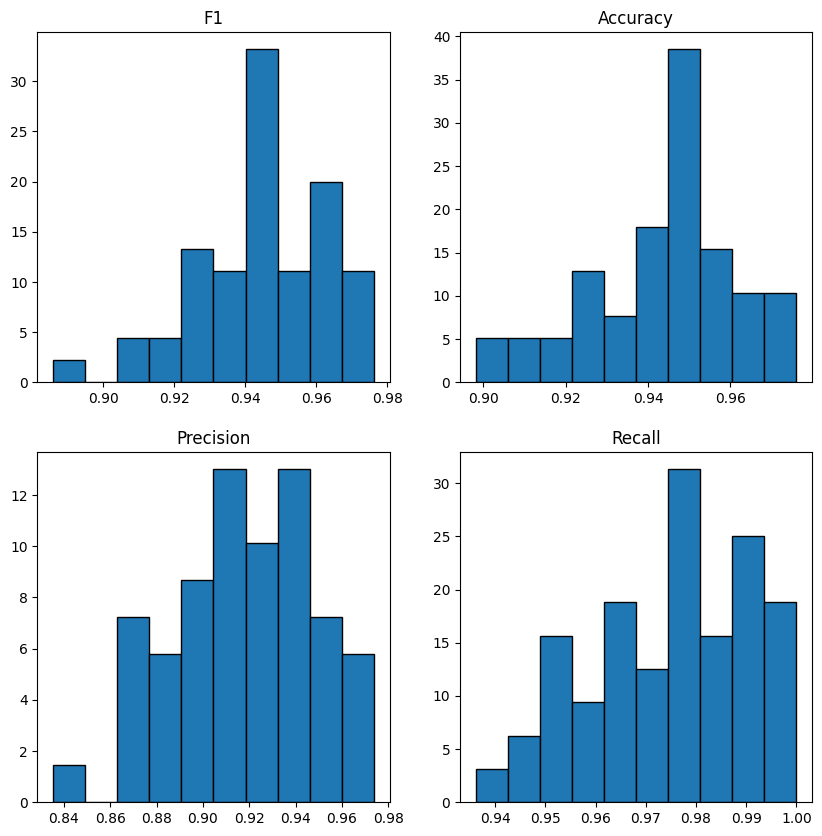

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    ax.hist(metric, bins=10, edgecolor='black', density=True)
    ax.set_title(name)
plt.show()

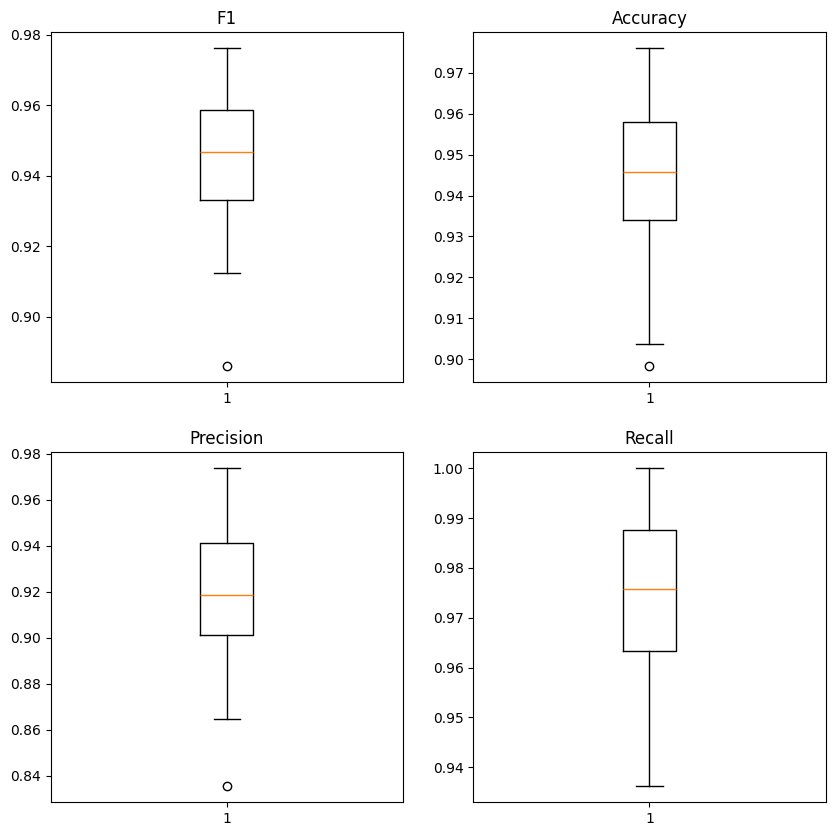

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    ax.boxplot(metric)
    
    ax.set_title(name)
plt.show()

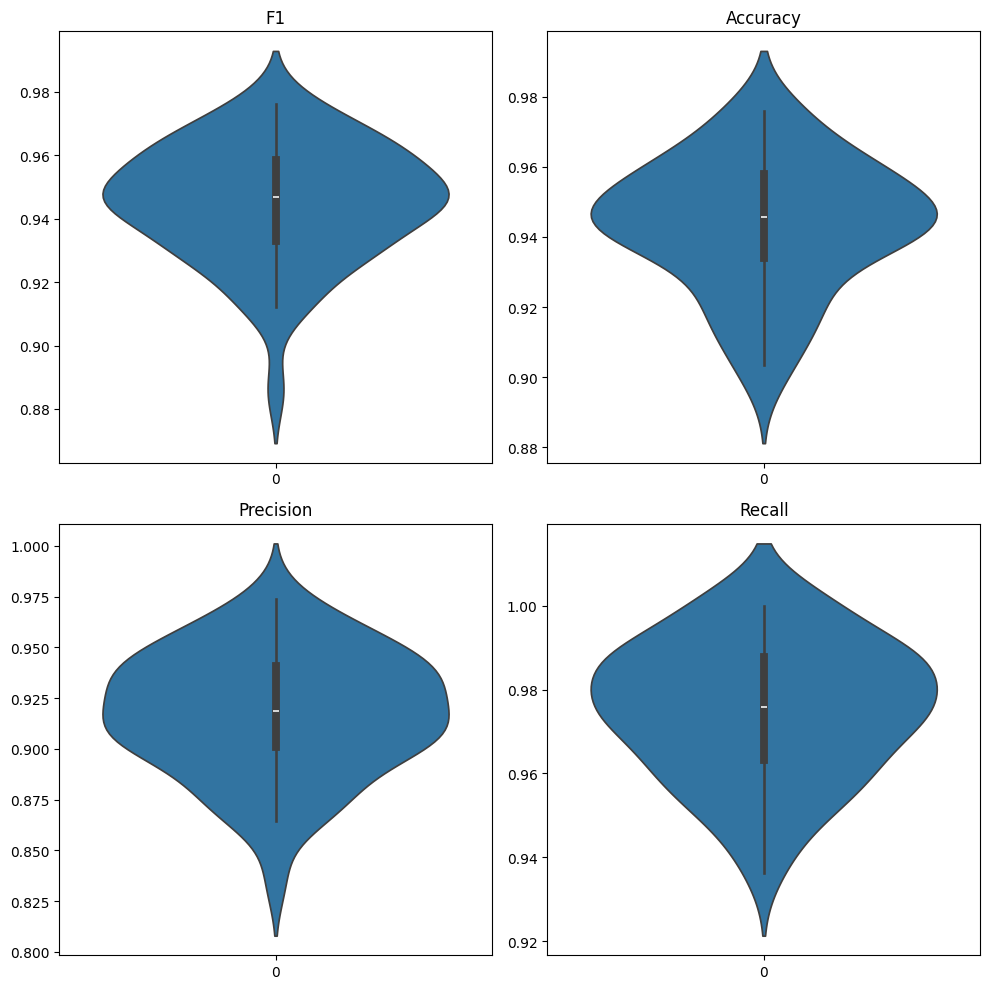

In [24]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Cria dois subplots lado a lado

# Violin plot with sns
for ax, metric, name in zip(axes.flatten(), [f1s, accuracies, precisions, recalls], ['F1', 'Accuracy', 'Precision', 'Recall']):
    sns.violinplot(data=[metric], ax=ax)
    
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [25]:
tfidf = pipeline.named_steps['prepro_features'].named_steps['tfidf']
log_reg = pipeline.named_steps['log_reg']
feature_names = tfidf.get_feature_names_out()
log_reg_coefficients = log_reg.coef_[0]
word_importance = log_reg_coefficients

In [26]:
top_n = 10
top_positive_indices = word_importance.argsort()[-top_n:]
top_negative_indices = word_importance.argsort()[:top_n]

print("Palavras que mais contribuem positivamente para a classe alvo:")
for idx in reversed(top_positive_indices):
    print(f"{feature_names[idx]}: {word_importance[idx]:.4f}")

print("\nPalavras que mais contribuem negativamente (associadas à classe oposta):")
for idx in top_negative_indices:
    print(f"{feature_names[idx]}: {word_importance[idx]:.4f}")

Palavras que mais contribuem positivamente para a classe alvo:
bird: 5.8809
trash: 5.3948
yankee: 4.9486
charlie: 4.4901
yellow: 4.2038
oreo: 3.2311
brownie: 3.1459
monkey: 2.6155
mock: 2.5368
colored: 2.4604

Palavras que mais contribuem negativamente (associadas à classe oposta):
bitch: -20.2489
hoe: -11.1534
pussy: -9.4196
shit: -5.6462
faggot: -5.3759
as: -5.0536
nigga: -4.9224
fuck: -4.8203
fag: -4.3871
nigger: -4.3233


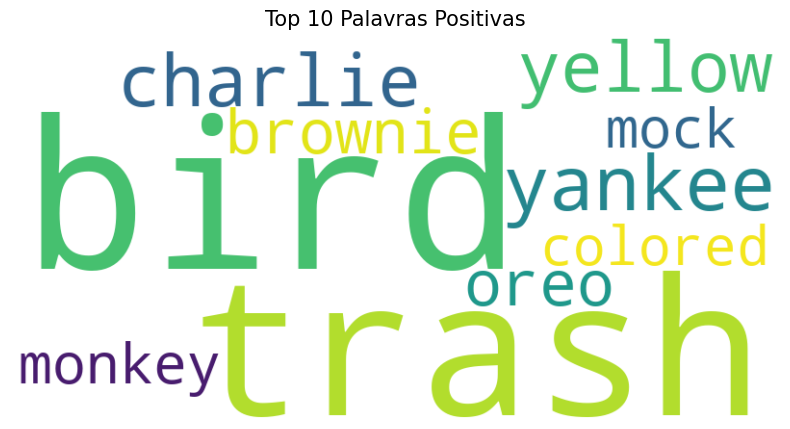

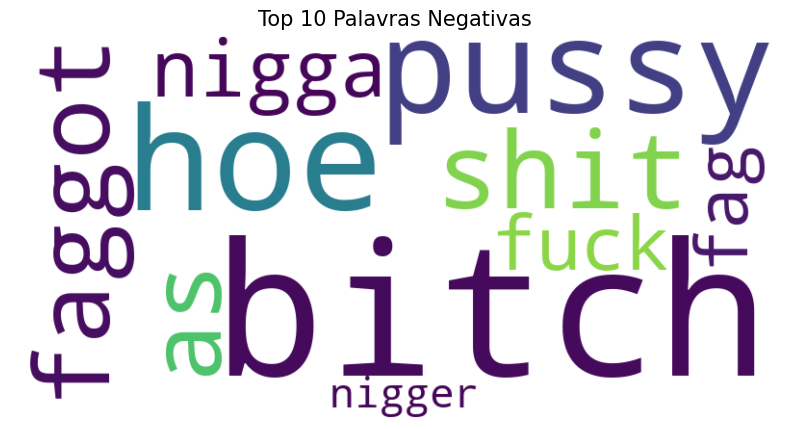

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_words = {feature_names[idx]: word_importance[idx] for idx in top_positive_indices}
negative_words = {feature_names[idx]: abs(word_importance[idx]) for idx in top_negative_indices}

def generate_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

generate_wordcloud(positive_words, "Top 10 Palavras Positivas")
generate_wordcloud(negative_words, "Top 10 Palavras Negativas")

## Modificando o tamanho do dataset

Vamos variar o tamanho do dataset gradativamente para enxergar o comportamento dos gráficos e das métricas de avaliação.

In [91]:
X, y = texts_target_undersampled['tweet'], texts_target_undersampled['class']

In [92]:
X.shape, y.shape, y.value_counts()

((8326,),
 (8326,),
 class
 0    4163
 1    4163
 Name: count, dtype: int64)

In [93]:
df = pd.concat([X, y], axis=1)

In [94]:
df.shape

(8326, 2)

100%|██████████| 20/20 [03:21<00:00, 10.06s/it]


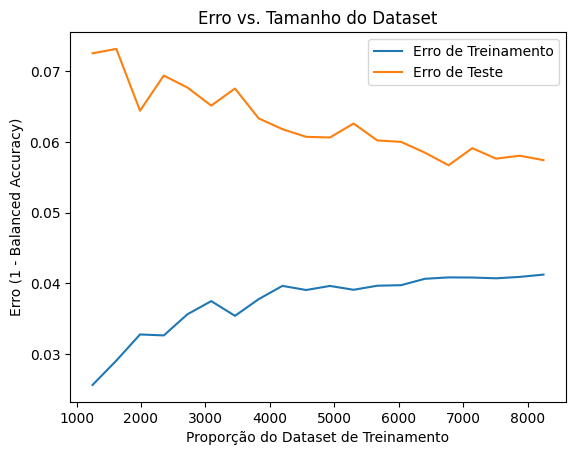

In [95]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

train_sizes = np.linspace(0.15, 0.99, 20)
train_errors = []
test_errors = []

for train_size in tqdm(train_sizes):
    pipelines = []
    train_errors_i = []
    test_errors_i = []
    for k in range(20):
        l = int(train_size * X.shape[0])
        sample = df.sample(l)
        X_sample, y_sample = sample['tweet'], sample['class']
        X_train, X_test, y_train, y_test = train_test_split(X_sample,
                                                            y_sample,
                                                            test_size=0.2,
                                                            random_state=42 + k,
                                                            stratify=y_sample)
        
        pipeline = create_model()
        pipeline.fit(X_train, y_train)
        train_error_i = 1 - balanced_accuracy_score(y_train, pipeline.predict(X_train))
        test_error_i = 1 - balanced_accuracy_score(y_test, pipeline.predict(X_test))
        train_errors_i.append(train_error_i)
        test_errors_i.append(test_error_i)
        pipelines.append(pipeline)

    train_error = np.mean(train_errors_i)
    train_errors.append(train_error)
    
    test_error = np.mean(test_errors_i)
    test_errors.append(test_error)
    

# Plotagem dos erros
plt.plot(train_sizes * X.shape[0], train_errors, label='Erro de Treinamento')
plt.plot(train_sizes * X.shape[0], test_errors, label='Erro de Teste')
plt.xlabel('Proporção do Dataset de Treinamento')
plt.ylabel('Erro (1 - Balanced Accuracy)')
plt.title('Erro vs. Tamanho do Dataset')
plt.legend()
plt.show()


In [96]:
test_errors = np.array(test_errors)
train_errors = np.array(train_errors)

s = test_errors + train_errors
d = test_errors - train_errors

In [97]:
log_d = np.log(d)
log_s = np.log(s)
x = np.log(train_sizes * X.shape[0])
y = log_d

In [102]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x.reshape(-1, 1), y)
print(reg.coef_[0], reg.intercept_)

-0.5817385533409737 1.12296844405307


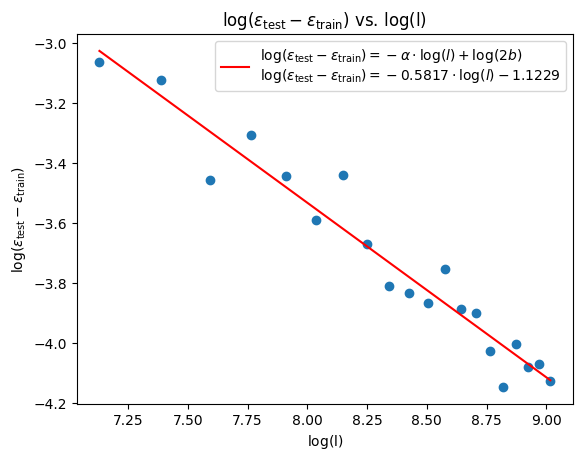

In [106]:
plt.scatter(x, y)
equation_ref = r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}}) = - \alpha \cdot \log(l) + \log(2b)$'
equation = r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}}) = -0.5817 \cdot \log(l) - 1.1229$'

plt.plot(x, reg.predict(x.reshape(-1, 1)), color='red', label=equation_ref + '\n' + equation)
plt.title(r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}})$ vs. $\log(\text{l})$')
plt.xlabel(r'$\log(\text{l})$')
plt.ylabel(r'$\log(\epsilon_{\text{test}} - \epsilon_{\text{train}})$')
plt.legend()
plt.show()

### Conclusão

A partir da análise do gráfico de **Erro vs. Tamanho do Dataset**, que avalia o desempenho do modelo em diferentes proporções do conjunto de dados de treinamento, é possível observar que tanto o erro de treinamento quanto o erro de teste diminuem conforme o tamanho do dataset aumenta. No entanto, à medida que mais dados são incluídos, o ganho de precisão começa a diminuir. Isso sugere que, embora haja espaço para melhorar a acurácia do modelo com o aumento do tamanho do dataset, os retornos em termos de redução do erro se tornam cada vez menores, especialmente ao nos aproximarmos do uso completo do dataset. Portanto, a adição de mais dados pode continuar a melhorar a performance, mas é necessário ponderar se os custos e o tempo de coleta de mais dados são viáveis no contexto do caso de negócio. No contexto presente, como o insumo de treino é oriundo das redes sociais, o trabalho pode ser facilitado com acesso às APIs das redes sociais, que podem fornecer um volume maior de dados para treinamento.

## 5. Análise de tópicos

Para explorar os tópicos presentes nos textos classificados, foi utilizada a técnica de modelagem de tópicos com NMF (Non-Negative Matrix Factorization). Através dessa técnica, foi possível identificar os tópicos mais relevantes presentes nos textos. O que nos permite entender melhor a performance do classificador para cada tópico e identificar possíveis melhorias.

In [80]:
class DominantTopic(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.argmax(X, axis=1)

pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
])

num_topics = 2

pipeline_nmf = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('nmf', NMF(n_components=num_topics)),
    ('dominant_topic', DominantTopic()),
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])


In [81]:
pipeline_nmf.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('nmf', NMF(n_components=2)),
                ('dominant_topic', DominantTopic())])

In [82]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer())])),
                ('log_reg', LogisticRegression())])

In [83]:
dominant_topics_train = pd.Series(pipeline_nmf.transform(X_train))
dominant_topic_test = pd.Series(pipeline_nmf.transform(X_test))

dominant_topics_train.index = X_train.index
dominant_topic_test.index = X_test.index

In [84]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return f1, accuracy, precision, recall

for topic in range(num_topics):
    print(f"Topic {topic}")
    
    X_test_topic = X_test[dominant_topic_test == topic]
    y_test_topic = y_test[dominant_topic_test == topic]
    
    f1, accuracy, precision, recall = evaluate_model(pipeline, X_test_topic, y_test_topic)
    
    print(f"F1: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("\n-------\n")

Topic 0
F1: 0.95
Accuracy: 0.95
Precision: 0.91
Recall: 0.99

-------

Topic 1
F1: 0.90
Accuracy: 0.91
Precision: 0.90
Recall: 0.90

-------



### Análise por tópico

É possível notar que para algums tópicos especificos o classificador se sai melhor! Agora, vamos treinar um classificador para cada tópicos específico e avaliar o desempenho de cada um deles.

In [85]:
# Dicionário para armazenar os modelos por tópico
topic_models = {}

for topic in tqdm(range(num_topics)):
    idx_train = np.where(dominant_topics_train == topic)[0]
    X_train_topic = X_train.iloc[idx_train]
    y_train_topic = y_train.iloc[idx_train]
    
    pipeline_prepro_features = Pipeline([
        ('prepro', PreproTweets()),
        ('tfidf', TfidfVectorizer()),
    ])

    
    pipeline_topic = Pipeline([
        ('prepro_features', pipeline_prepro_features),
        ('log_reg', LogisticRegression()),
    ])
    
    pipeline_topic.fit(X_train_topic, y_train_topic)
        
    # Armazena o modelo para o tópico
    if topic not in topic_models:
        topic_models[topic] = []
    topic_models[topic].append(pipeline_topic)

100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


In [86]:
for topic in range(num_topics):
    print(f"Topic {topic}")
    pipeline_ = topic_models[topic][0]
    X_test_topic = X_test[dominant_topic_test == topic]
    y_test_topic = y_test[dominant_topic_test == topic]
    
    f1, accuracy, precision, recall = evaluate_model(pipeline_, X_test_topic, y_test_topic)
    
    print(f"F1: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("\n-------\n")

Topic 0
F1: 0.95
Accuracy: 0.95
Precision: 0.92
Recall: 0.99

-------

Topic 1
F1: 0.89
Accuracy: 0.90
Precision: 0.88
Recall: 0.90

-------



In [90]:
f1, accuracy, precision, recall = evaluate_model(pipeline, X_test_topic, y_test_topic)
    
print(f"F1: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n-------\n")

F1: 0.90
Accuracy: 0.91
Precision: 0.90
Recall: 0.90

-------



In [91]:
class TwoLayerClassifier:
    def __init__(self, topic_models, pipeline_nmf):
        self.topic_models = topic_models
        self.pipeline_nmf = pipeline_nmf
        
    def predict(self, X):
        dominant_topics = self.pipeline_nmf.transform(X)
        y_pred = []
        for idx, topic in enumerate(dominant_topics):
            y_pred_topic = self.topic_models[topic][0].predict([X.iloc[idx]])
            y_pred.append(y_pred_topic[0])
        return np.array(y_pred)

In [92]:
two_layer_classifier = TwoLayerClassifier(topic_models, pipeline_nmf)

In [94]:
f1, accuracy, precision, recall = evaluate_model(two_layer_classifier, X_test, y_test)

print(f"F1: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("\n-------\n")

F1: 0.94
Accuracy: 0.94
Precision: 0.91
Recall: 0.97

-------



### Conclusão do Two Layer Classifier

É possível notar que a performace do modelo quando ele é desenvolvido em duas camadas é melhor do que o modelo único. Isso se dá pelo fato de que o modelo consegue aprender melhor as características de cada tópico e classificar de forma mais precisa. A especificidade do modelo é um fator importante para a classificação de textos, pois permite que instâncias mais complexas de textos sejam tratadas de maneira mais específica e eficiente. 

Nesse sentido, é de suma importância que implementações como a análise de tópicos para a construção de modelos de classificação de texto nas redes sociais sejam consideradas, pois elas podem melhorar significativamente a performance do modelo e a qualidade das previsões, melhorando assim a experiência do usuário e a segurança online.